# Классификация текста

## Cодержание
- [Data preprocessing](#Data-preprocessing)
- [Embeddings](#Embeddings)
- [Dataloader](#Dataloader)
- [CNN](#CNN)

In [1]:
import os
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F


from tqdm import tqdm
from typing import Tuple, Dict
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
os.chdir('../../')

## Data preprocessing

In [5]:
base_data_path = 'data/datasets/ag_news'

train_data_path = os.path.join(base_data_path, 'ag_news_train.csv')
test_data_path = os.path.join(base_data_path, 'ag_news_test.csv')

In [6]:
train_data = pd.read_csv(train_data_path, sep='\t')
test_data = pd.read_csv(test_data_path, sep='\t')

In [7]:
train_corpus = train_data.text
test_corpus = test_data.text

In [8]:
train_labels = train_data['label']
test_labels = test_data['label']

In [9]:
print(f"train sise: {len(train_data)}")
print(f"test size: {len(test_data)}")

train sise: 120000
test size: 7600


In [10]:
def tokenize_text(texts):
    return [re.findall(r'\w+', text.lower()) for text in tqdm(texts)]

train_data_tokenized = tokenize_text(train_corpus)
test_data_tokenized = tokenize_text(test_corpus)

100%|███████████████████████████████████| 7600/7600 [00:00<00:00, 100966.09it/s]


In [11]:
stop_words = stopwords.words('english')

def remove_stopwords(texts):
    return [
        [word for word in words if word not in stop_words]
        for words in tqdm(texts)
    ]

train_data_tokenized = remove_stopwords(train_data_tokenized)
test_data_tokenized = remove_stopwords(test_data_tokenized)

100%|████████████████████████████████████| 7600/7600 [00:00<00:00, 13574.19it/s]


In [12]:
def lemmatize_text(texts):
    lemmatizer = WordNetLemmatizer()
    return [
        [lemmatizer.lemmatize(word) for word in words]
        for words in tqdm(texts)
    ]

train_data_lemmatized = lemmatize_text(train_data_tokenized)
test_data_lemmatized = lemmatize_text(test_data_tokenized)

100%|████████████████████████████████████| 7600/7600 [00:00<00:00, 11512.83it/s]


## Embeddings

In [13]:
w2v_model = Word2Vec(
    train_data_lemmatized,
    vector_size=100,
    min_count=5,
    window=5
).wv

In [14]:
def encode_dataset(dataset):
    encoded = []
    for words in tqdm(dataset):
        vectors = [w2v_model.get_vector(word) for word in words if word in w2v_model]
        encoded.append(torch.from_numpy(np.array(vectors)))
    return encoded

train_embeddings = encode_dataset(train_data_lemmatized)
test_embeddings = encode_dataset(test_data_lemmatized)

100%|████████████████████████████████████| 7600/7600 [00:00<00:00, 28367.00it/s]


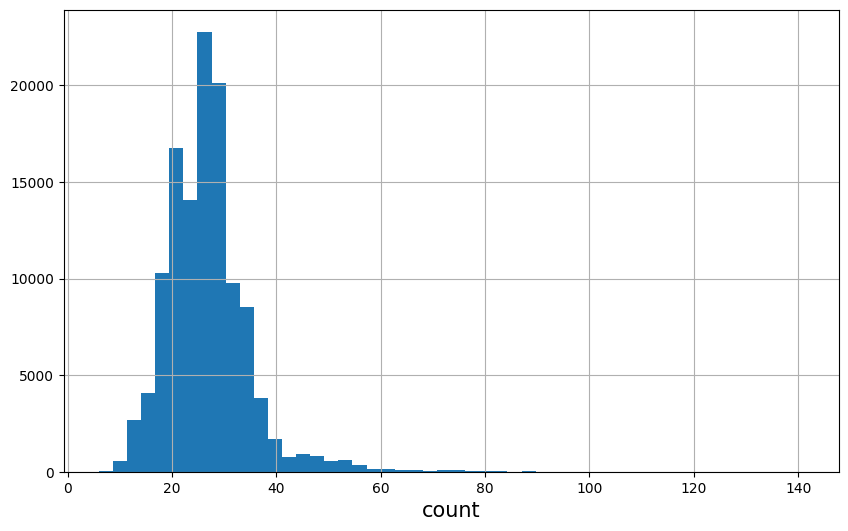

In [15]:
text_lens = [len(x) for x in train_embeddings]

plt.figure(figsize=(10, 6))
plt.hist(text_lens, bins=50)
plt.xlabel("text length", size=15)
plt.xlabel("count", size=15)
plt.grid()
plt.show()

## Dataloader

In [16]:
train_dataset = list(zip(train_embeddings, train_labels))
test_dataset = list(zip(test_embeddings, test_labels))

In [17]:
def collate_fn(batch):
    x, labels = zip(*batch)
    return pad_sequence(x).permute(1, 0, 2), torch.tensor(labels)

In [18]:
w2v_train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=True, batch_size=32)
w2v_test_loader = DataLoader(test_dataset, collate_fn=collate_fn, shuffle=False, batch_size=8)

In [19]:
batch = next(iter(w2v_train_loader))
print(batch[0].shape)
batch

torch.Size([32, 53, 100])


(tensor([[[ 0.0356,  0.4639, -0.1771,  ...,  0.1870, -0.0534, -0.2484],
          [ 1.7351, -3.1082,  0.1002,  ..., -2.7402, -0.6524, -4.5370],
          [ 0.5510, -0.2031, -0.6764,  ...,  0.1170, -0.5325, -0.5663],
          ...,
          [-0.4532, -0.4133, -1.7463,  ...,  1.0284, -2.7490,  1.1424],
          [ 0.2637, -1.6686, -0.1973,  ..., -1.6795, -3.6260,  1.5278],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.4068,  0.1982, -2.3062,  ..., -2.0291, -2.3351,  1.3839],
          [ 0.8654,  0.4126, -0.8647,  ...,  1.3474, -1.3865, -0.8672],
          [-0.4733, -2.0179, -0.3721,  ..., -1.8034,  1.5964,  0.7236],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-1.8510,  1.7366,  1.9420,  ..., -1.5229, -1.9120, -1.4961],
          [-0.1332,  0.1386,

## CNN

In [51]:
class SimpleCNN(nn.Module):
    def __init__(self, hid_dim=100, n_classes=4):
        super().__init__()
        
        self.conv1 = nn.Conv1d(
            in_channels=hid_dim,
            out_channels=hid_dim,
            kernel_size=3,
            stride=1,
            padding=1
        )
        
        self.conv2 = nn.Conv1d(
            in_channels=hid_dim,
            out_channels=hid_dim,
            kernel_size=3,
            stride=1,
            padding=1
        )
        
        self.fc = nn.Linear(hid_dim, n_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x: torch.Tensor):
        # [batch_size, seq_len, hid_dim] -> [batch_size, hid_dim, seq_len]
        x = x.permute(0, 2, 1)
        
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        

        x = F.max_pool1d(x, x.size(-1)).squeeze(dim=-1)
        
        x = self.fc(x)
        return x
    
model = SimpleCNN()
model(batch[0])

tensor([[-0.1630,  0.0634,  0.0085,  0.3411],
        [-0.0073,  0.1743,  0.0030,  0.2526],
        [-0.1060,  0.1517,  0.1127,  0.1177],
        [-0.1950,  0.0594,  0.0767,  0.2082],
        [-0.0810,  0.0971,  0.0608,  0.0664],
        [-0.0723, -0.0100, -0.0104,  0.2572],
        [ 0.0433,  0.0204, -0.0162,  0.1582],
        [-0.0602,  0.1298,  0.1083,  0.1103],
        [ 0.0351, -0.0083,  0.0069,  0.1284],
        [-0.0426,  0.1917,  0.1165,  0.3026],
        [ 0.0213, -0.0498, -0.0078,  0.1808],
        [-0.0931,  0.0416,  0.0741,  0.1475],
        [-0.1665,  0.2865,  0.0621,  0.1500],
        [-0.1445,  0.1221,  0.1027,  0.1184],
        [ 0.0063,  0.1794,  0.0732,  0.2207],
        [-0.0889,  0.0705,  0.1369,  0.1756],
        [-0.0926,  0.1266,  0.1931,  0.2147],
        [-0.0731,  0.0405, -0.0300,  0.0731],
        [-0.0277,  0.1130,  0.1276,  0.0694],
        [ 0.0183,  0.0205,  0.0700,  0.0979],
        [-0.1292,  0.1817,  0.0506,  0.0747],
        [-0.0155, -0.0514,  0.0333

In [52]:
def train_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
) -> Tuple[float, float]:
    """Train model for one epoch.
    
    Args:
        model: Neural network model
        dataloader: Training data loader
        optimizer: Optimization algorithm
        device: Device to run training on (cpu/cuda)
        logger: Optional logger function to track metrics
        
    Returns:
        Tuple of (average loss, accuracy) for the epoch
    """
    model.train()
    criterion = nn.CrossEntropyLoss()
    
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    for batch_idx, (tokens, labels) in enumerate(dataloader):
        tokens = tokens.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        # Forward pass
        logits = model(tokens)
        loss = criterion(logits, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        # Calculate metrics
        preds = logits.argmax(dim=-1)
        correct = (preds == labels).sum().item()
        
        total_loss += loss.item() * labels.size(0)
        total_correct += correct
        total_samples += labels.size(0)
    
    # Calculate epoch metrics
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    
    return avg_loss, accuracy


@torch.inference_mode()
def evaluate(
    model: nn.Module, 
    dataloader: DataLoader,
    device: torch.device,
) -> Tuple[float, float]:
    """Evaluate model performance.
    
    Args:
        model: Neural network model
        dataloader: Evaluation data loader
        device: Device to run evaluation on (cpu/cuda)
        logger: Optional logger function to track metrics
        
    Returns:
        Tuple of (average loss, accuracy)
    """
    model.eval()
    criterion = nn.CrossEntropyLoss()
    
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    for tokens, labels in dataloader:
        tokens = tokens.to(device)
        labels = labels.to(device)
        
        logits = model(tokens)
        loss = criterion(logits, labels)
        
        preds = logits.argmax(dim=-1)
        correct = (preds == labels).sum().item()
        
        total_loss += loss.item() * labels.size(0)
        total_correct += correct
        total_samples += labels.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    
    return avg_loss, accuracy

In [53]:
model = SimpleCNN().to(device)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,  # У learning rate
    weight_decay=1e-5  # регуляризация
)

In [54]:
num_epochs = 5
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(
        model=model,
        dataloader=w2v_train_loader,
        optimizer=optimizer,
        device=device
    )
    val_loss, val_acc = evaluate(
        model=model,
        dataloader=w2v_test_loader,
        device=device
    )
    
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

Epoch 1: Train Loss: 0.3205, Acc: 0.8891 | Val Loss: 0.2892, Acc: 0.8987
Epoch 2: Train Loss: 0.2644, Acc: 0.9075 | Val Loss: 0.2853, Acc: 0.9032
Epoch 3: Train Loss: 0.2374, Acc: 0.9169 | Val Loss: 0.2797, Acc: 0.9033
Epoch 4: Train Loss: 0.2173, Acc: 0.9238 | Val Loss: 0.2842, Acc: 0.9034
Epoch 5: Train Loss: 0.1983, Acc: 0.9302 | Val Loss: 0.2838, Acc: 0.9092


[К содержанию](#Cодержание)